In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix # imports the csr_matrix function from the scipy.sparse module
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import scipy

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [2]:
mpl.rcParams['figure.dpi'] = 450

Set parameters

In [3]:
neighbors = 15
fineNeighborhood = 4
coarseNeighborhood = 3

colors = {"DCT": "#800515",
               "Endothelium": "#7ae031",
               "UB_CT": "black",
               "Podocyte": "#ad9c00", 
               "Stroma": "#794b82",
               "NPC": "#ff8000", 
               "PT": "#ff00d4", 
               "Int": "#698cff",
               "Ureth": "#d47222", 
               "PEC": "#ff0011", 
               "LOH": "#235e00",
               "Immune Cells": '#757575',
               "Nephron":"#698cff",
         }

In [4]:
adata = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/model2/fetal_PostSCANVI_imputedExpression.h5ad")
adata = adata[adata.obs["tech"] == "CosMx"]
print(adata)

View of AnnData object with n_obs × n_vars = 377959 × 24485
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge', 'AllCounts', '_scvi_batch', '_scvi_labels', 'mean_distance', 'worst_pct', 'cellType_SCANVI', 'leiden_sub18', 'neighbors', 'Endothelium_neighbor', 'UB_CT_neighbor', 'Stroma_neighbor', 'Podocyte_neighbor', 'PT_neighbor', 'PEC_neighbor', 'LOH_neighbor', 'Int_neighbor', 'DCT_neighbor', 'Immune Cells_neighbor', 'Ureth_neighbor', 'DCT_absorbtion_SCVI', 'LOH_absorbtion_SCVI', 'PT_absorbtion_SCVI', 'Podo_absorbtion_SCVI', 'NPC_SCVI', 'Differentiated Cell_SCVI', 'Tubule_SCVI', 'Glomerular_SCVI', 'LatentTime_SCVI', 'PseudoTime_SCVI'
    uns: 'phase_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scANVI', 'X_scVI', 'X_uma

In [5]:
print(adata.obs_names)

Index(['1_1-0', '2_1-0', '3_1-0', '4_1-0', '5_1-0', '6_1-0', '7_1-0', '8_1-0',
       '9_1-0', '10_1-0',
       ...
       '1468_69-2', '1472_69-2', '1473_69-2', '1477_69-2', '1478_69-2',
       '1482_69-2', '1490_69-2', '1491_69-2', '1493_69-2', '1494_69-2'],
      dtype='object', length=377959)


In [6]:
adata1 = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/ligandScores_all_ligands.h5ad")


In [7]:
print(adata1.obs_names)

Index(['4_1-1', '5_1-1', '8_1-1', '35_1-1', '36_1-1', '39_1-1', '40_1-1',
       '42_1-1', '43_1-1', '45_1-1',
       ...
       '2906_220-0', '2907_220-0', '2908_220-0', '2909_220-0', '2910_220-0',
       '2913_220-0', '2916_220-0', '2918_220-0', '2919_220-0', '2920_220-0'],
      dtype='object', length=377959)


In [8]:
adata1.obs["renew"] = adata.obs["NPC_SCVI"]
adata1.obs["dif"] = adata.obs['Differentiated Cell_SCVI']

adata1.obs["podocyte"] = adata.obs["Podo_absorbtion_SCVI"]
adata1.obs["pt"] = adata.obs["PT_absorbtion_SCVI"]
adata1.obs["loh"] = adata.obs["LOH_absorbtion_SCVI"]
adata1.obs["dct"] = adata.obs["DCT_absorbtion_SCVI"]

adata1.obs["tubule"] = adata.obs["Tubule_SCVI"]
adata1.obs["glom"] = adata.obs["Glomerular_SCVI"]

adata1.obs["pseudo"] = adata.obs["PseudoTime_SCVI"]
adata1.obs["cellType_SCANVI"] = adata.obs["cellType_SCANVI"]
print(adata1.obs["cellType_SCANVI"])

adataPT = adata1[adata1.obs["cellType_SCANVI"] == "PT"]
print(adataPT)

4_1-1            Int
5_1-1            Int
8_1-1            Int
35_1-1           Int
36_1-1           Int
               ...  
2913_220-0    Stroma
2916_220-0     UB_CT
2918_220-0    Stroma
2919_220-0        PT
2920_220-0        PT
Name: cellType_SCANVI, Length: 377959, dtype: category
Categories (11, object): ['DCT', 'Endothelium', 'Immune Cells', 'Int', ..., 'Podocyte', 'Stroma', 'UB_CT', 'Ureth']
View of AnnData object with n_obs × n_vars = 33174 × 878
    obs: 'sample', 'renew', 'dif', 'podocyte', 'pt', 'loh', 'dct', 'tubule', 'glom', 'pseudo', 'cellType_SCANVI'
    uns: 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [9]:
renew_correlations = []
dif_correlations = []

podo_correlations = []
pt_correlations = []
loh_correlations = []
dct_correlations = []

tubule_correlations = []
glom_correlations = []

pseudo_correlation = []

for i in range(adata1.shape[1]):
    gene_expression = adataPT.X[:, i].toarray().flatten()
    gene_expression = gene_expression[~np.isnan(gene_expression)]
    renew = adataPT.obs["renew"][~np.isnan(gene_expression)]
    dif = adataPT.obs["dif"][~np.isnan(gene_expression)]
    
    pt = adataPT.obs["pt"][~np.isnan(gene_expression)]
    podo = adataPT.obs["podocyte"][~np.isnan(gene_expression)]
    loh = adataPT.obs["loh"][~np.isnan(gene_expression)]
    dct = adataPT.obs["dct"][~np.isnan(gene_expression)]

    tubule = adataPT.obs["tubule"][~np.isnan(gene_expression)]
    glom = adataPT.obs["glom"][~np.isnan(gene_expression)]
    
    pseudo = adataPT.obs["pseudo"][~np.isnan(gene_expression)]

    
    # Calculate correlations
    correlation_renew = np.corrcoef(gene_expression, renew)[0, 1]
    correlation_dif = np.corrcoef(gene_expression, dif)[0, 1]
    
    correlation_pt = np.corrcoef(gene_expression, pt)[0, 1]
    correlation_podo = np.corrcoef(gene_expression, podo)[0, 1]
    correlation_loh = np.corrcoef(gene_expression, loh)[0, 1]
    correlation_dct = np.corrcoef(gene_expression, dct)[0, 1]

    correlation_glom = np.corrcoef(gene_expression, glom)[0, 1]
    correlation_tub = np.corrcoef(gene_expression, tubule)[0, 1]
    
    correlation_pseudo = np.corrcoef(gene_expression, pseudo)[0, 1]
    
    renew_correlations.append(correlation_renew)
    dif_correlations.append(correlation_dif)
    
    pt_correlations.append(correlation_pt)
    podo_correlations.append(correlation_podo)
    loh_correlations.append(correlation_loh)
    dct_correlations.append(correlation_dct)
    
    glom_correlations.append(correlation_glom)
    tubule_correlations.append(correlation_tub)

    pseudo_correlation.append(correlation_pseudo)

df = pd.DataFrame({'Ligand': adata1.var_names.tolist(), 'Renew': renew_correlations, "Diff": dif_correlations,
                  "PT": pt_correlations, "Podocyte": podo_correlations, "LOH": loh_correlations, "DCT": dct_correlations,
                  "Tubule": tubule_correlations, "Glom": glom_correlations, "PseudoTime": pseudo_correlation})

print(df)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


    Ligand     Renew      Diff        PT  Podocyte       LOH       DCT  \
0     ACE2 -0.372259  0.187189  0.489551 -0.460125 -0.427511 -0.490171   
1    ACKR1       NaN       NaN       NaN       NaN       NaN       NaN   
2    ACKR2  0.001103 -0.013893 -0.010564  0.009039  0.008306  0.010213   
3    ACKR3 -0.054295  0.002563  0.031744 -0.009724 -0.083806 -0.086801   
4    ACKR4 -0.010193  0.005966  0.005627  0.004672 -0.030694 -0.029734   
..     ...       ...       ...       ...       ...       ...       ...   
873   XCL1 -0.001418  0.001276  0.003987 -0.002312 -0.009002 -0.006317   
874   XCL2  0.097165 -0.058359 -0.042324  0.034604  0.043249  0.057994   
875   XCR1 -0.002063  0.004589  0.004032 -0.000434 -0.010398 -0.012015   
876   XPR1 -0.053002  0.035453  0.095327 -0.068409 -0.137450 -0.143860   
877   YARS  0.097785 -0.100695 -0.113795  0.091962  0.124700  0.142371   

       Tubule      Glom  PseudoTime  
0    0.455238 -0.460125    0.546163  
1         NaN       NaN         NaN

In [10]:
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

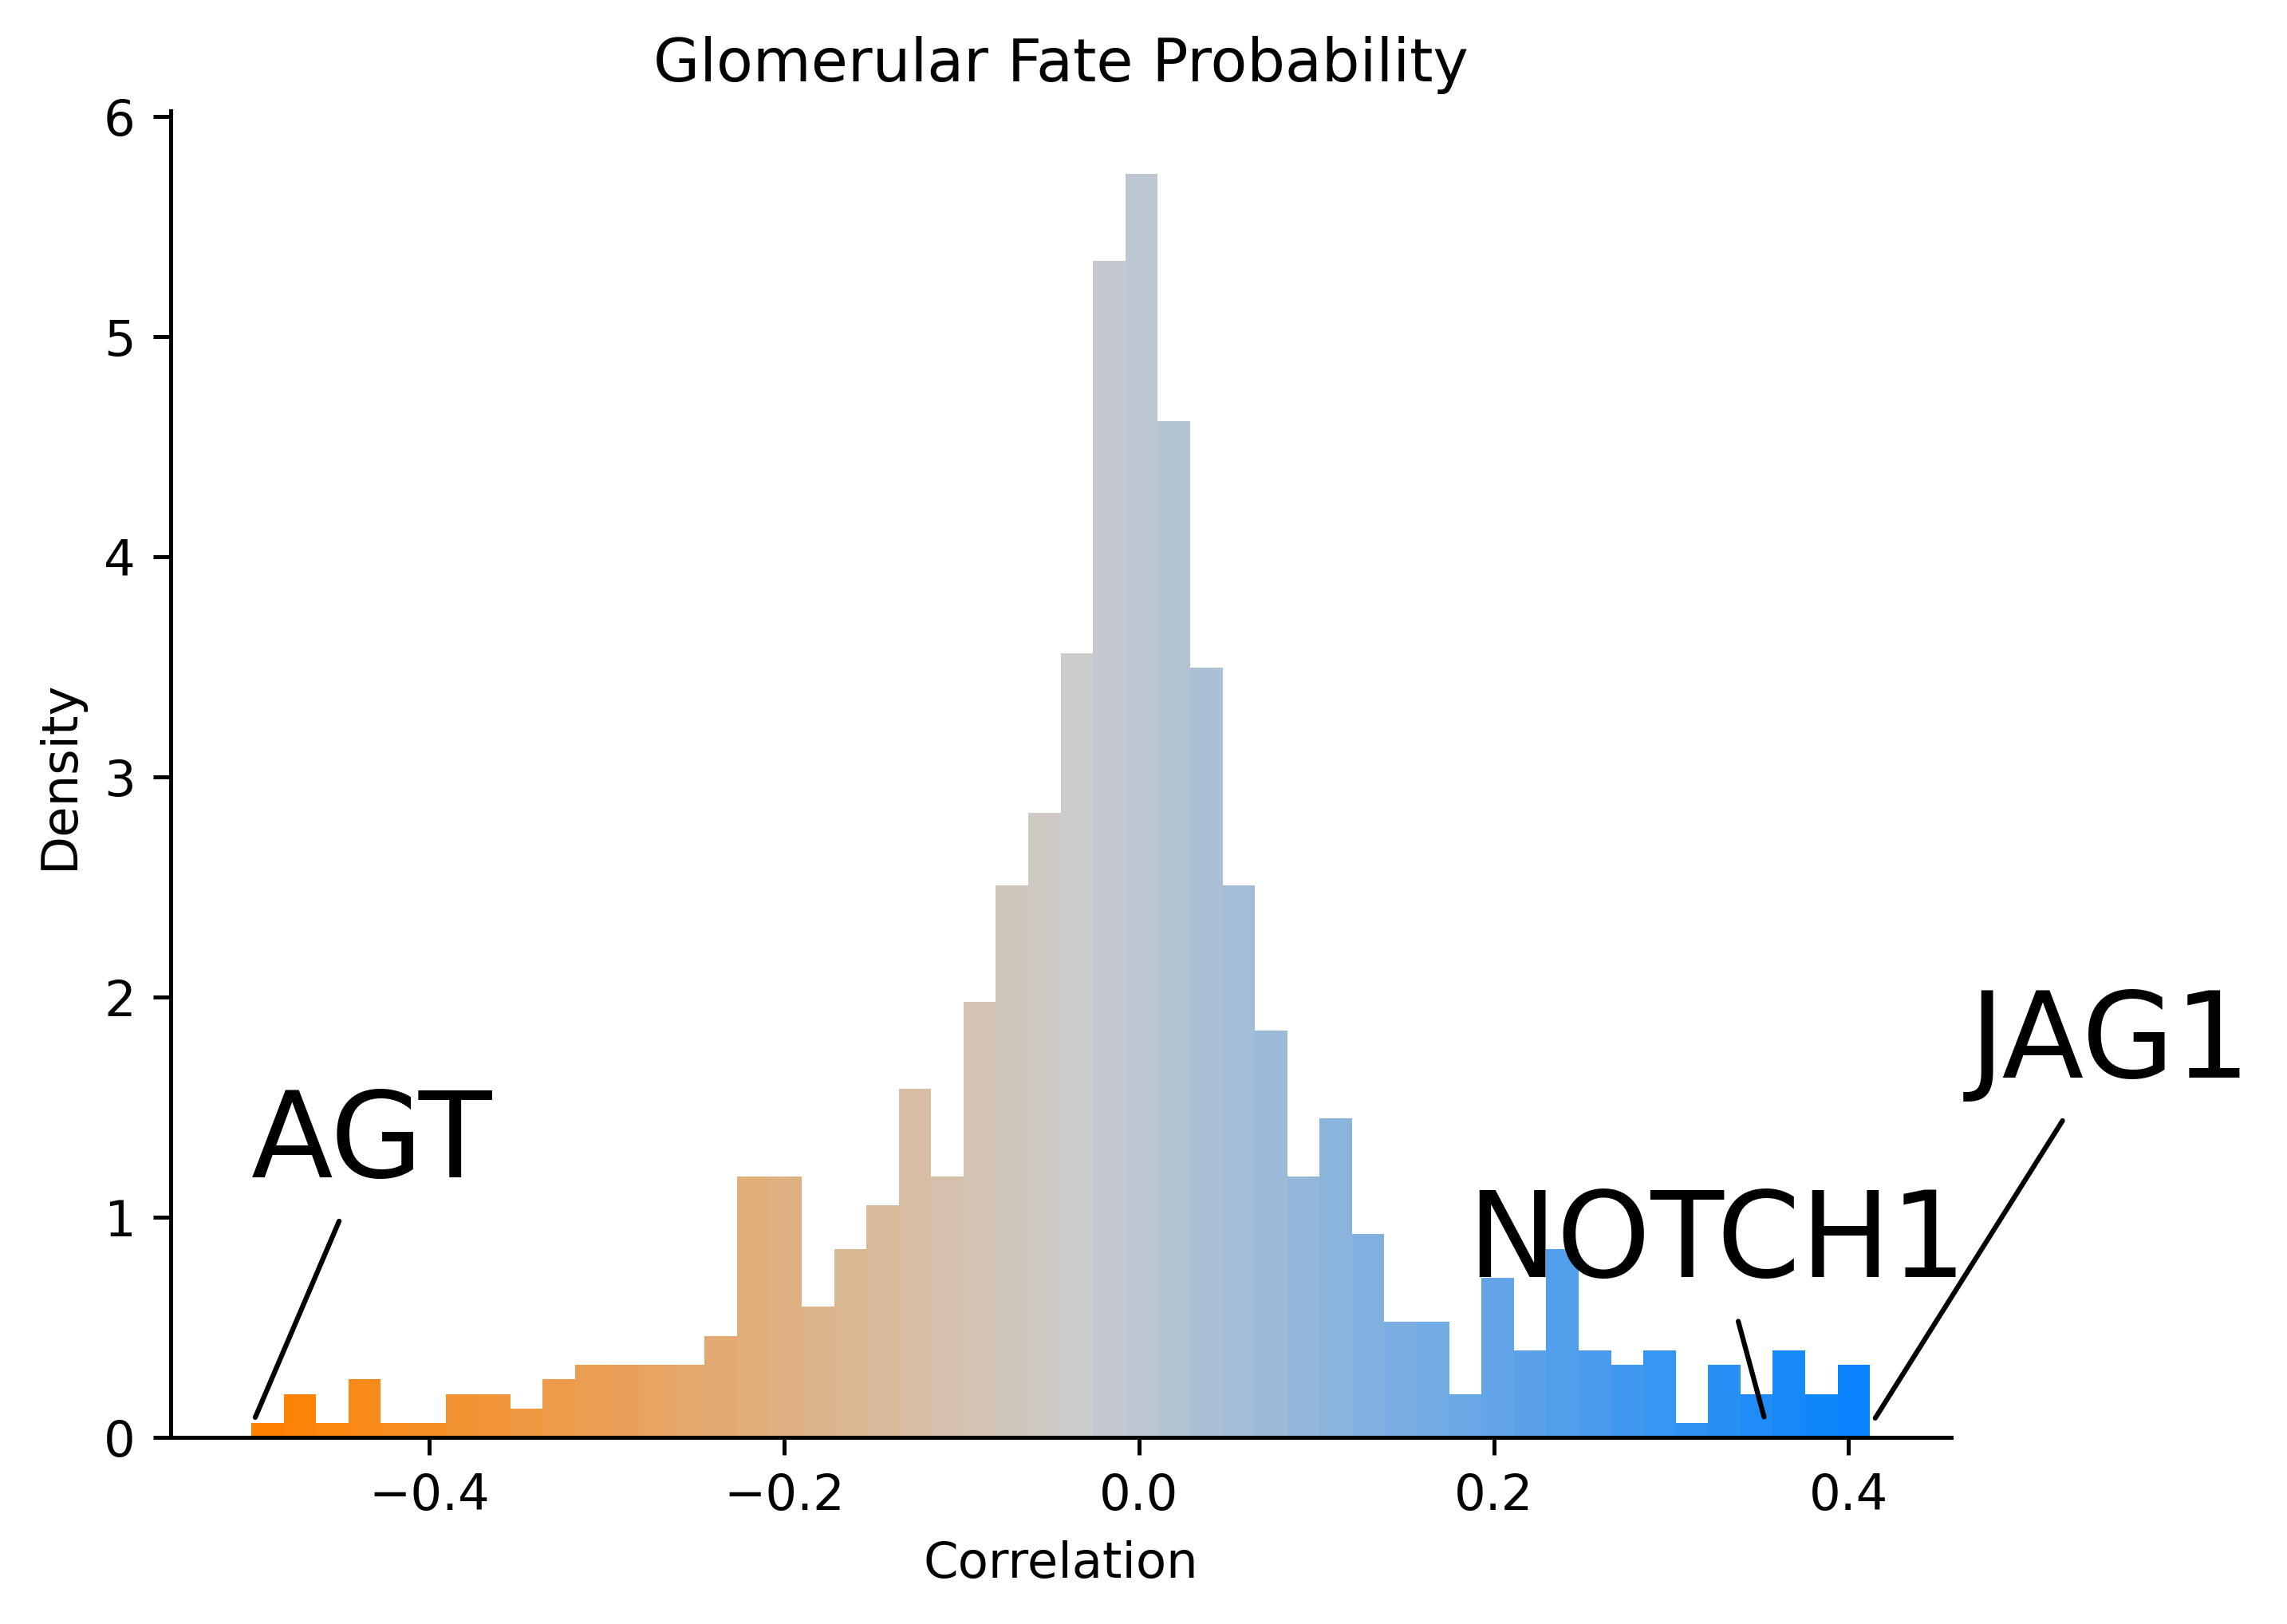

In [11]:
colors = [
    (1, 0.5, 0),  # Orange
    (0.8, 0.8, 0.8),  # Grey
    (0, 0.5, 1),  # Blue
]

# Create the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("orange_grey_blue", colors)

n, bins, patches = plt.hist(df['Glom'], bins=50, density = True)

# Normalize the bin values for color mapping
norm = plt.Normalize(bins.min(), bins.max())

# Color each bar based on its x-position
for patch, bin_value in zip(patches, bins):
    color = cmap(norm(bin_value))
    patch.set_facecolor(color)
    
agt_index = df[df['Ligand'] == "AGT"].index[0]
jag_index = df[df['Ligand'] == "JAG1"].index[0]
notch1_index = df[df['Ligand'] == "NOTCH1"].index[0]
notch2_index = df[df['Ligand'] == "NOTCH2"].index[0]


plt.annotate("AGT", xy=(df['Glom'][agt_index], 0.05), xytext=( 0, 50), textcoords="offset points", arrowprops=dict(arrowstyle="-"), fontsize=24)
plt.annotate("JAG1", xy=(df['Glom'][jag_index], 0.05), xytext=(20, 70), textcoords="offset points", arrowprops=dict(arrowstyle="-"), fontsize=24)
plt.annotate("NOTCH1", xy=(df['Glom'][notch1_index], 0.05), xytext=(-60, 30), textcoords="offset points", arrowprops=dict(arrowstyle="-"), fontsize=24)


plt.title("Glomerular Fate Probability")
plt.xlabel("Correlation")
plt.ylabel("Density")

# Show the plot
plt.show()

In [12]:
df.to_csv('/home/levinsj/spatial/adata/project_Files/Fetal/ligandCorr_PT_only.csv')
